In [106]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import json
class Layer():
  def __init__(self):
    pass
  def forward(self):
    pass
  def backward(self):
    pass

Linear Layer

In [107]:
class Linear(Layer):
  def __init__(self,features_in,features_out):
    self.weights = np.random.randn(features_in,features_out) * np.sqrt(2/features_in)
    self.bias = 0.001 * np.random.randn(1,features_out)
   

  def forward(self,X):
    self.input = X
    self.Y_pred = np.dot(X,self.weights) + self.bias
    return self.Y_pred

  def backward(self,grad,alpha):
    grad_input = np.dot(grad,self.weights.T)
    grad_weights = np.dot(self.input.T,grad)
    grad_bias = np.sum(grad, axis=0, keepdims=True)

    self.weights = (self.weights - alpha  * grad_weights)
    self.bias = (self.bias - alpha  * grad_bias)
    return grad_input
  
  def get_weights(self):
        return self.weights

  def get_bias(self):
        return self.bias

  def set_weights(self,w):
      self.weights = w

  def set_bias(self,b):
      self.bias = b

Sigmoid Function

In [108]:
class Sigmoid(Layer):
  def __init__(self):
    pass

  def forward(self,data):
    data = np.clip(data, -400 ,400)
    self.Y_pred = 1/(1+np.exp(-data))
    return self.Y_pred

  def backward(self,grad,alpha):
    return grad * self.Y_pred *(1-self.Y_pred)#here derivative of sigmoid is self.output *(1-self.output) 

HyperbolicTangentFunction


In [109]:
class HyperbolicTan(Layer):
  def __init__(self):
     self.Y_pred = None
    
    
  def forward(self,data):
    self.Y_pred = np.tanh(data)
    return self.Y_pred

  def backward(self,grad,alpha):
    tanh_derivative = 1 - self.Y_pred**2
    self.grad_tanh = tanh_derivative * grad
    return self.grad_tanh


Softmax function

In [110]:
class Softmax(Layer):
  def __init__(self):
    self.Y_pred =None

  def forward(self,X):
    num = np.exp(X - np.max(X))
    self.Y_pred_softmax = num / np.sum(num, axis=0, keepdims=True)
    return self.Y_pred_softmax

  def backward(self,grad,alpha):
    grad_output = grad * self.Y_pred_softmax * (1 - self.Y_pred_softmax)
    return grad_output
    

Cross Entropy Loss

In [111]:
#binary cross entropy loss
class CrossEntropyLoss(Layer):
    def __init__(self):
        self.eps = 1e-15

    def forward(self, Y, Y_pred):
        self.Y = Y
        self.Y_pred = np.clip(Y_pred, 1e-7, 1 - 1e-7)
        self.loss = -np.mean(Y * np.log(self.Y_pred) + (1 - Y) * np.log(1 - self.Y_pred))
        return self.loss

    def backward(self,alpha):
      self.loss_backward = (self.Y_pred - self.Y) / (self.Y_pred * (1 - self.Y_pred) + 1e-7)
      return self.loss_backward


Sequential class

In [112]:

class Sequential(Layer):
  def __init__(self,layers):
    self.layers = layers
  
  def forward(self,data):
    self.out = data
    for l in self.layers:
      self.out = l.forward(self.out)

    return self.out

  def backward(self,grad,alpha):
    self.grad_in = grad
    for i in reversed(self.layers):
      self.grad_in = i.backward(self.grad_in,alpha)
    return self.grad_in

  def save_weights(self):
    i = 0
    w = {}
    b = {}
    for layer in self.layers:
      if isinstance(layer, Linear):
        w[i] = layer.get_weights()
        b[i] = layer.get_bias()
        i+=1
    for key in w:
      w[key] = w[key].tolist()
    for key in b:
      b[key] = b[key].tolist()
    with open("weight.json", "w") as json_file:
      json.dump(w, json_file)
    with open("bias.json", "w") as json_file:
      json.dump(b, json_file)

  def load_weights(self):
    
    with open('weight.json', 'r') as f:
        w = json.load(f)    
    with open('bias.json', 'r') as f:
        b = json.load(f)    
    i = 0
    for key in w:
      w[key] = np.array(w[key])
    for key in b:
      b[key] = np.array(b[key])
    
    
    for layer in self.layers:
      if isinstance(layer, Linear):
        
        layer.set_weights(w[str(i)])
        layer.set_bias(b[str(i)])
        i+=1
      


In [113]:
#Define model for xor using sigmoid activation function

In [114]:
linear1 = Linear(2,2)
sigmoid1 = Sigmoid()
linear2 = Linear(2,1)
sigmoid2 = Sigmoid()
HyperbolicTan1 = HyperbolicTan()
HyperbolicTan2 = HyperbolicTan()
model1 = Sequential([linear1,sigmoid1,linear2,sigmoid2])

Train XOR model using Sigmoid activation

In [115]:
# Train the model using sigmoid  activation

X_train = np.array([[0, 0],[0, 0],[0, 0], [0, 1],[0, 1],[0, 1], [1, 0], [1, 1], [1, 1], [1, 1],[1, 1],[1, 1]])
Y_train = np.array([[0], [0], [0], [1], [1], [1], [1], [0], [0], [0],[0],[0]])
alpha = 0.01

loss_fn = CrossEntropyLoss()
epochs = 10000
l_loss = []
for epoch in range(epochs):
    # Forward pass
    output = model1.forward(X_train)
    loss = loss_fn.forward(Y_train,output)#loss in forward pass using cross entropy loss
    l_loss.append(loss)
    
    # Backward pass
    grad_output = loss_fn.backward(alpha)# gradient in backward pass using cross entropy
    model1.backward(grad_output,alpha)

In [116]:
# save the model weights in weight.json file and bias.json
model1.save_weights()

In [117]:
#load the updated weights and bias saved in file
model1.load_weights()

In [118]:
#for prediction without running the training data again we can run this using saved and updated weights
X_train1 = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])#4*2
Y_train1 = np.array([[0], [1], [1], [0]])#4*1

# Verify the model
Y_pred = model1.forward(X_train1)
Y_pred = np.round(Y_pred).flatten()
accuracy_sigmoid = accuracy_score(Y_train1, Y_pred)

print(f"Accuracy for XOR using sigmoid: {accuracy_sigmoid*100} % ")

Accuracy for XOR using sigmoid: 100.0 % 


Train model to solve XOR problem using hyperbolic tangent function

In [119]:
# Train the model using hyperbolic tangent  activation
model2 = Sequential([linear1,HyperbolicTan1,linear2,HyperbolicTan2])
loss_fn = CrossEntropyLoss()
epochs = 10000
l_loss = []
for epoch in range(epochs):
    # Forward pass
    output = model2.forward(X_train)

    loss = loss_fn.forward(Y_train,output)#loss in forward pass using cross entropy loss
    l_loss.append(loss)
    # Backward pass
    grad_output = loss_fn.backward(alpha)# gradient in backward pass using cross entropy
    model2.backward(grad_output,alpha)


# Verify the model
Y_pred = model2.forward(X_train)
Y_pred = np.round(Y_pred).flatten()
accuracy_hyper = accuracy_score(Y_train, Y_pred)

print(f"Accuracy of XOR using hyperbolic tangent: {accuracy_hyper*100} % ")


Accuracy of XOR using hyperbolic tangent: 33.33333333333333 % 


Accuracy using Sigmoid for solving XOR problem  is 100% and weights are saved in a file "XOR_solved.pkl" and loaded

In [120]:
import tensorflow as tf #used for loading mnist data
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import np_utils


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)


x_train = x_train.reshape(x_train.shape[0], -1) 
x_test = x_test.reshape(x_test.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

MNIST model with 2 Linear layers and with sigmoid activation function after each layer with epochs=100 and learning rate 0.001

Accuracy MNIST Model1: 9.8 % 


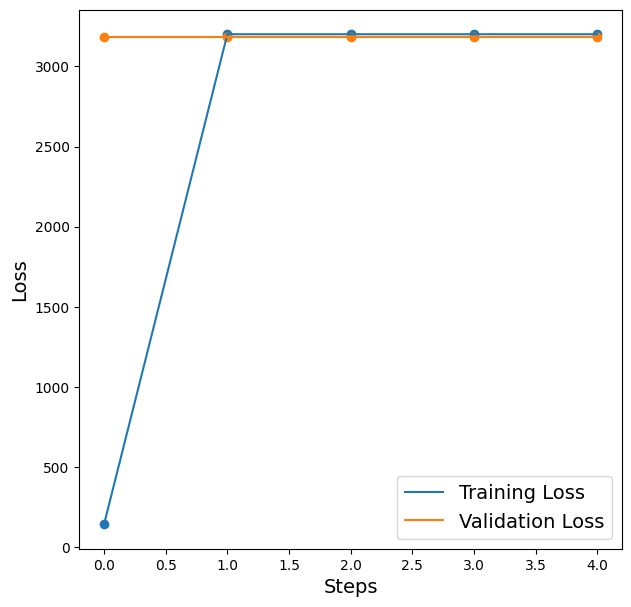

In [121]:
model_mnist1 = Sequential([Linear(784,200),Sigmoid(),Linear(200,10),Sigmoid()])
# Train the model using sigmoid  activation
loss_fn_mnist = CrossEntropyLoss()
alpha = 0.1
epochs = 100
patience = 5
l_loss = []
l_mseloss = []
l_epochs = []
best_train_loss = float("inf")
best_val_loss = float("inf")
for epoch in range(epochs):
    # Forward pass
    output = model_mnist1.forward(x_train)
    loss_mnist = loss_fn_mnist.forward(y_train,output.T)#loss in forward pass using cross entropy loss
    # # Backward pass
    grad_output_mnist = loss_fn_mnist.backward(alpha)# gradient in backward pass using cross entropy
    model_mnist1.backward(grad_output_mnist.T,alpha)
    val_output = model_mnist1.forward(x_val)
    val_mse = loss_fn_mnist.forward(y_val,val_output.T)

    if val_mse < best_val_loss:
      best_val_loss = val_mse
      count = 0
    else:
      count += 1

    if count == patience:
      break
    l_mseloss.append(val_mse)
    l_loss.append(loss_mnist)
    l_epochs.append(epoch)

y_pred_test = model_mnist1.forward(x_test)
ypred_labels = np.argmax(y_pred_test, axis=1)
accuracy_MNIST= accuracy_score(y_test, ypred_labels)
print(f"Accuracy MNIST Model1: {accuracy_MNIST*100} % ")

plt.figure(figsize=(7, 7))
plt.plot(l_epochs, l_loss, label='Training Loss')
plt.plot(l_epochs, l_mseloss, label='Validation Loss')
plt.scatter(l_epochs, l_loss)
plt.scatter(l_epochs, l_mseloss)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()


MNIST model with 3 Linear layers and with hyperbolictan activation function after each layer with epochs=100 and learning rate=1

Accuracy MNIST Model2: 10.15 % 


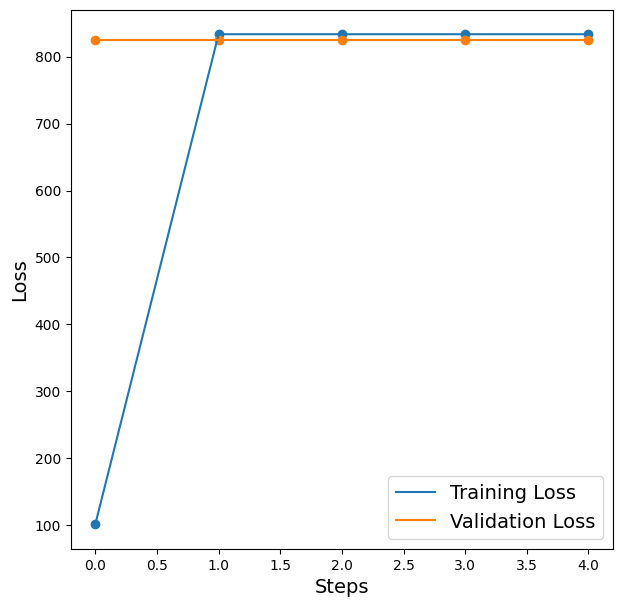

In [122]:
linear_mnist3 = Linear(784,66)
hp_mnist3 = HyperbolicTan()
linear_mnist4 = Linear(66,20)
hp_mnist4 = HyperbolicTan()
linear_mnist5 = Linear(20,10)
hp_mnist5 = HyperbolicTan()

model_mnist2 = Sequential([linear_mnist3,hp_mnist3,linear_mnist4,hp_mnist4,linear_mnist5,hp_mnist5])

# Train the model using sigmoid  activation
loss_fn_mnist = CrossEntropyLoss()
alpha = 1
epochs = 100
patience = 5
l_loss = []
l_mseloss = []
l_epochs = []
best_train_loss = float("inf")
best_val_loss = float("inf")
for epoch in range(epochs):
    # Forward pass
    output = model_mnist2.forward(x_train)
    loss_mnist = loss_fn_mnist.forward(y_train,output.T)#loss in forward pass using cross entropy loss
    # # Backward pass
    grad_output_mnist = loss_fn_mnist.backward(alpha)# gradient in backward pass using cross entropy
    model_mnist2.backward(grad_output_mnist.T,alpha)
    val_output = model_mnist2.forward(x_val)
    val_mse = loss_fn_mnist.forward(y_val,val_output.T)

    if val_mse < best_val_loss:
      best_val_loss = val_mse
      count = 0
    else:
      count += 1

    if count == patience:
      break
    l_mseloss.append(val_mse)
    l_loss.append(loss_mnist)
    l_epochs.append(epoch)

y_pred_test = model_mnist2.forward(x_test)
ypred_labels = np.argmax(y_pred_test, axis=1)
accuracy_MNIST1= accuracy_score(y_test, ypred_labels)
print(f"Accuracy MNIST Model2: {accuracy_MNIST1*100} % ")

plt.figure(figsize=(7, 7))
plt.plot(l_epochs, l_loss, label='Training Loss')
plt.plot(l_epochs, l_mseloss, label='Validation Loss')
plt.scatter(l_epochs, l_loss)
plt.scatter(l_epochs, l_mseloss)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()



MNIST model with 2 Linear layers and with hyperbolictan activation function after each layer with epochs=100 and learning rate=0.01

Accuracy MNIST Model3: 3.53 % 


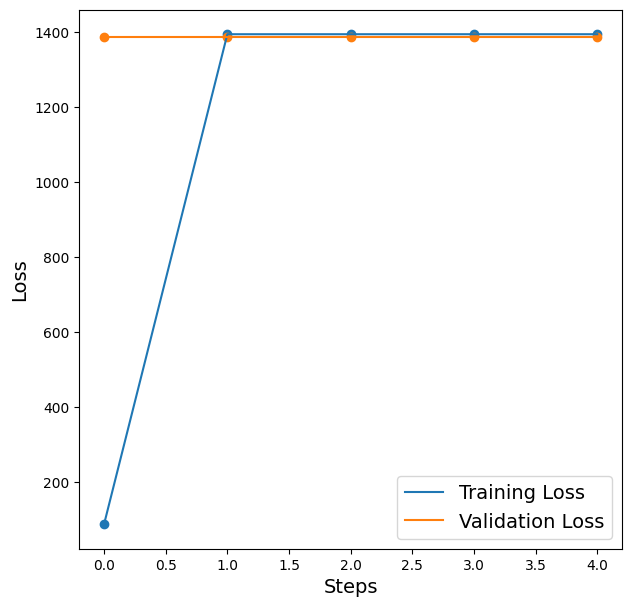

In [123]:
linear_mnist6 = Linear(784,100)
hp_mnist6 = HyperbolicTan()
linear_mnist7 = Linear(100,10)
hp_mnist7 = HyperbolicTan()

model_mnist3 = Sequential([linear_mnist6,hp_mnist6,linear_mnist7,hp_mnist7])

loss_fn_mnist = CrossEntropyLoss()
alpha = 0.01
epochs = 100
patience = 5
l_loss = []
l_mseloss = []
l_epochs = []

best_val_loss = float("inf")
for epoch in range(epochs):
    # Forward pass
    output = model_mnist3.forward(x_train)
    loss_mnist = loss_fn_mnist.forward(y_train,output.T)#loss in forward pass using cross entropy loss
    # # Backward pass
    grad_output_mnist = loss_fn_mnist.backward(alpha)# gradient in backward pass using cross entropy
    model_mnist3.backward(grad_output_mnist.T,alpha)
    val_output = model_mnist3.forward(x_val)
    val_mse = loss_fn_mnist.forward(y_val,val_output.T)

    if val_mse < best_val_loss:
      best_val_loss = val_mse
      count = 0
    else:
      count += 1

    if count == patience:
      break
    l_mseloss.append(val_mse)
    l_loss.append(loss_mnist)
    l_epochs.append(epoch)

y_pred_test = model_mnist3.forward(x_test)
ypred_labels = np.argmax(y_pred_test, axis=1)
accuracy_MNIST3= accuracy_score(y_test, ypred_labels)
print(f"Accuracy MNIST Model3: {accuracy_MNIST3*100} % ")

plt.figure(figsize=(7, 7))
plt.plot(l_epochs, l_loss, label='Training Loss')
plt.plot(l_epochs, l_mseloss, label='Validation Loss')
plt.scatter(l_epochs, l_loss)
plt.scatter(l_epochs, l_mseloss)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()
